# Analyze 6 models for 5 datasets
## Make a variety of plots, analyze each type of model
### Document the findings

In [56]:
import json
import csv
import os
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def read_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def read_log(file_path):
    with open(file_path, 'r') as file:
        return file.readlines()

def read_text(file_path):
    with open(file_path, 'r') as file:
        return file.read()

def read_csv(file_path):
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        return [row for row in reader]

def parse_files(base_dir, model, study, size):
    directory = os.path.join(base_dir, f"{model}", study, size.upper())
    files = {
        "best": glob.glob(os.path.join(directory, "best-*.json")),
        "log": glob.glob(os.path.join(directory, "deap-*.log")),
        "fitnesses": glob.glob(os.path.join(directory, "fitnesses-*.txt")),
        "fitness": glob.glob(os.path.join(directory, "fitness-*.txt")),
        "hyperparams": glob.glob(os.path.join(directory, "*param*.json")),
        "cfg": glob.glob(os.path.join(directory, "cfg-*.sh")),
        "hpo": [os.path.join(directory, "hpo.csv")]
    }
    print(files)
    data = {}
    
    data['best'] = [read_json(file) for file in files['best']]
    data['log'] = [read_log(file) for file in files['log']]
    data['fitnesses'] = [read_text(file) for file in files['fitnesses']]
    data['fitness'] = [read_text(file) for file in files['fitness']]
    data['hyperparams'] = [read_json(file) for file in files['hyperparams']]
    data['cfg'] = [read_text(file) for file in files['cfg']]
    data['hpo'] = [read_csv(file) for file in files['hpo']]
    
    return data

def extract_values(hpo_data):
    header = hpo_data[0]  # First row is the header
    data = hpo_data[1:]  # Remaining rows are the data

    # Create a mapping of column names to their indices
    column_indices = {name: index for index, name in enumerate(header)}

    # Extract the necessary values using the column names
    iterations = []
    results = []
    learning_rates = []
    batch_sizes = []

    # LGBM does not have batch size
    
    # Define default values for columns
    default_values = {
        'iteration': '0',
        'sample': '0000',
        'result': '0.0',
        'learning_rate': '0.0',
        'batch_size': '0'
    }

    for row in data:
        # Extract values using the column indices if they exist, otherwise use defaults
        iteration = row[column_indices['iteration']] if 'iteration' in column_indices else default_values['iteration']
        sample = row[column_indices['sample']] if 'sample' in column_indices else default_values['sample']
        result = row[column_indices['result']] if 'result' in column_indices else default_values['result']
        learning_rate = row[column_indices['learning_rate']] if 'learning_rate' in column_indices else default_values['learning_rate']
        batch_size = row[column_indices['batch_size']] if 'batch_size' in column_indices else default_values['batch_size']
    
        
        iterations.append(int(iteration))
        results.append(float(result))
        learning_rates.append(float(learning_rate))
        batch_sizes.append(int(batch_size))
    
    return iterations, results, learning_rates, batch_sizes


# GraphDRP analysis 

## GraphDRP populate all large runs

--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/LARGE/best-98.json'], 'log': ['./GraphDRP/gCSI/LARGE/deap-98.log'], 'fitnesses': ['./GraphDRP/gCSI/LARGE/fitnesses-98.txt'], 'fitness': ['./GraphDRP/gCSI/LARGE/fitness-98.txt'], 'hyperparams': ['./GraphDRP/gCSI/LARGE/graphdrp_param_space-3.json'], 'cfg': [], 'hpo': ['./GraphDRP/gCSI/LARGE/hpo.csv']}
--- Processing model: GraphDRP, study: CCLE ---
{'best': ['./GraphDRP/CCLE/LARGE/best-98.json'], 'log': ['./GraphDRP/CCLE/LARGE/deap-98.log'], 'fitnesses': ['./GraphDRP/CCLE/LARGE/fitnesses-98.txt'], 'fitness': ['./GraphDRP/CCLE/LARGE/fitness-98.txt'], 'hyperparams': ['./GraphDRP/CCLE/LARGE/graphdrp_param_space-3.json'], 'cfg': [], 'hpo': ['./GraphDRP/CCLE/LARGE/hpo.csv']}
--- Processing model: GraphDRP, study: GDSCv2 ---
{'best': ['./GraphDRP/GDSCv2/LARGE/best-398.json'], 'log': ['./GraphDRP/GDSCv2/LARGE/deap-398.log'], 'fitnesses': ['./GraphDRP/GDSCv2/LARGE/fitnesses-398.txt'], 'fitness': ['./GraphDRP/GDSCv2/LARGE/

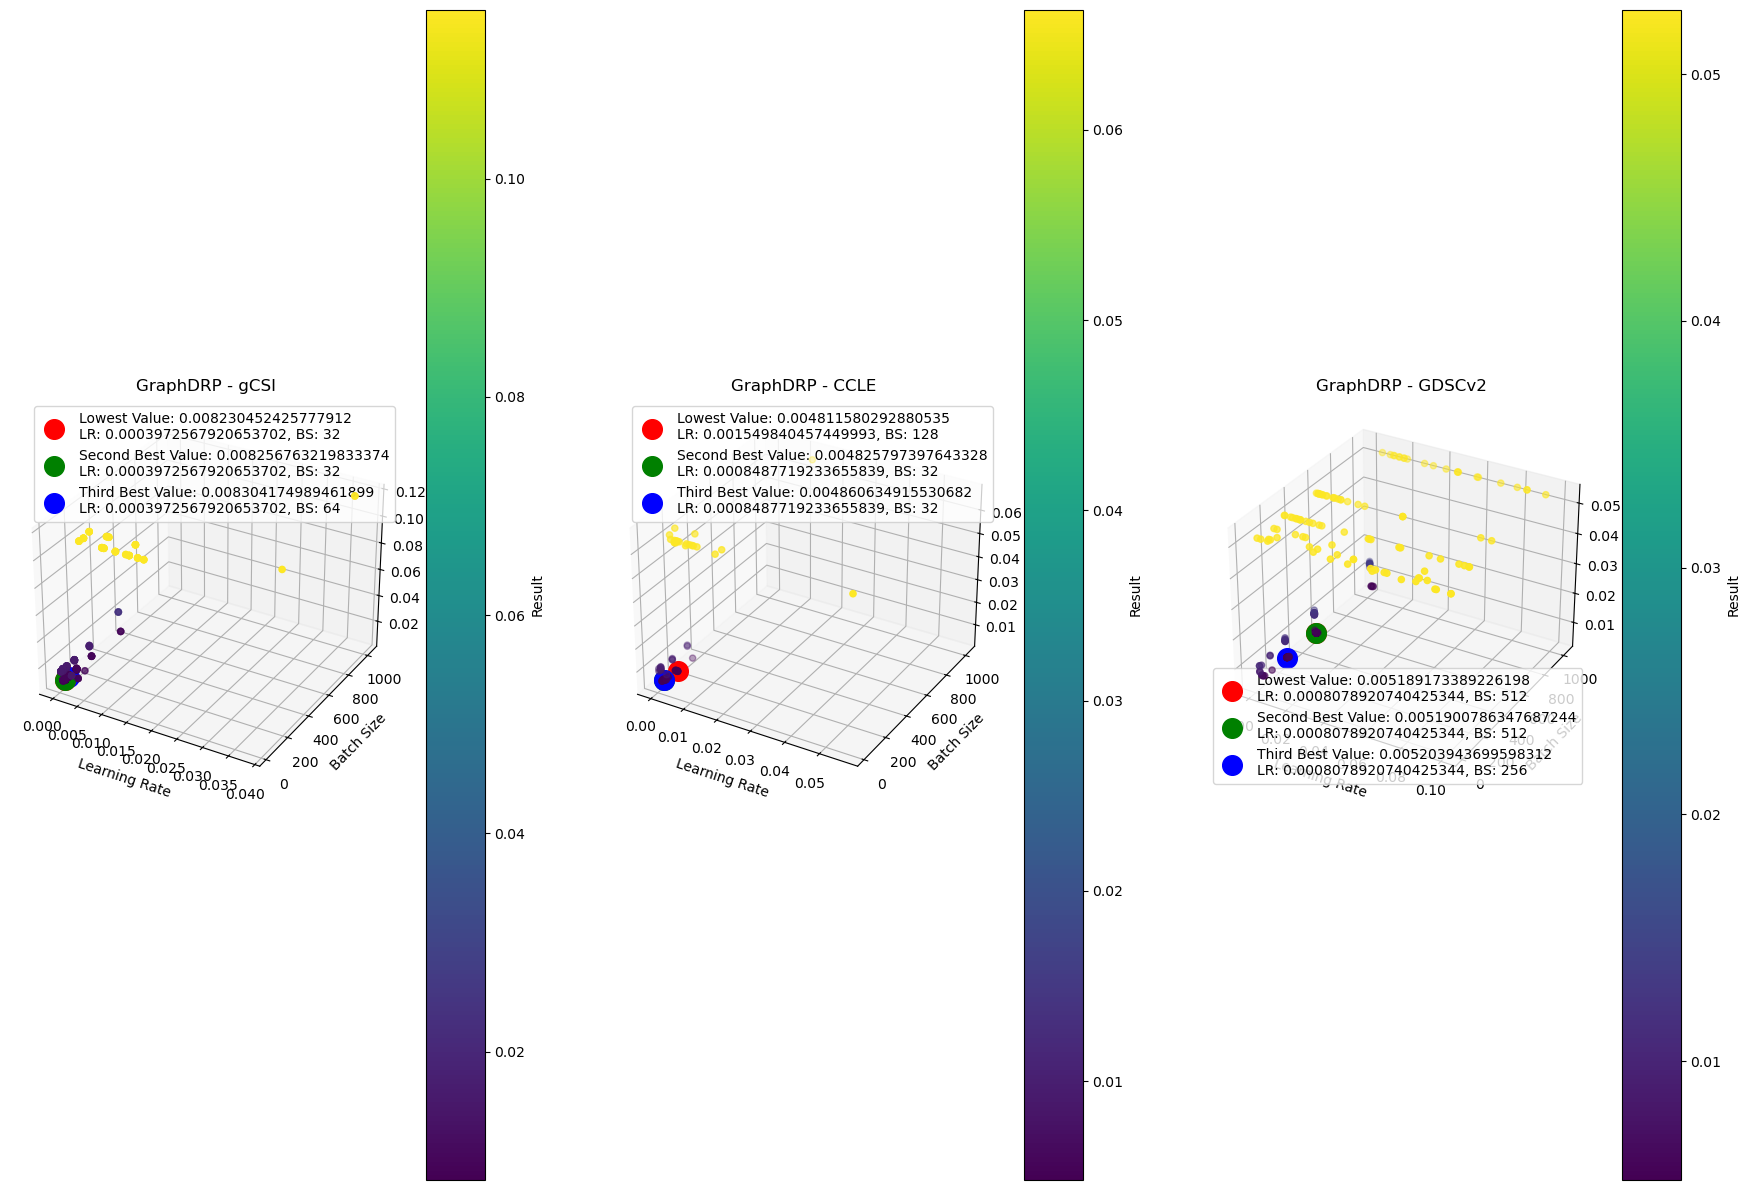

In [57]:

base_dir = "."
models = ["GraphDRP"]
# studies = ["gCSI", "GDSCv1", "CCLE", "GDSCv2"] gdscv1, CTRP not available! aug 6th 2024
studies = ["gCSI", "CCLE", "GDSCv2"]

size = "large"

fig = plt.figure(figsize=(18, 12))
extra_min = 2

for i, model in enumerate(models):
    for j, study in enumerate(studies):
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size)
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        
        # Find the indices of the best, second best, and third best results
        sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
        min_index = sorted_indices[0]        
        min_result = results[min_index]
        min_lr = learning_rates[min_index]
        min_bs = batch_sizes[min_index]

        # Initialize second and third best indices to the first index
        second_best_index = min_index
        third_best_index = min_index

        # Find the second and third best distinct results
        for idx in sorted_indices[1:]:
            if results[idx] != min_result:
                second_best_index = idx
                break

        for idx in sorted_indices[1:]:
            if results[idx] != min_result and results[idx] != results[second_best_index]:
                third_best_index = idx
                break

        # If all results are the same, ensure we pick some other values
        if second_best_index == min_index:
            second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
        if third_best_index == min_index:
            third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

        second_best_result = results[second_best_index]
        second_best_lr = learning_rates[second_best_index]
        second_best_bs = batch_sizes[second_best_index]

        third_best_result = results[third_best_index]
        third_best_lr = learning_rates[third_best_index]
        third_best_bs = batch_sizes[third_best_index]

        
        ax = fig.add_subplot(len(models), len(studies), i * len(studies) + j + 1, projection='3d')
        scatter = ax.scatter(learning_rates, batch_sizes, results, c=results, cmap='viridis')
        ax.scatter(min_lr, min_bs, min_result, color='r', s=200, label=f'Lowest Value: {min_result} \nLR: {min_lr}, BS: {min_bs}')
        ax.scatter(second_best_lr, second_best_bs, second_best_result, color='g', s=200, label=f'Second Best Value: {second_best_result}\nLR: {second_best_lr}, BS: {second_best_bs}')
        ax.scatter(third_best_lr, third_best_bs, third_best_result, color='b', s=200, label=f'Third Best Value: {third_best_result}\nLR: {third_best_lr}, BS: {third_best_bs}')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_zlabel('Result')
        ax.set_title(f'{model} - {study}')
        ax.legend()
        fig.colorbar(scatter, ax=ax, label='Result')

plt.tight_layout()
plt.show()


# GraphDRP Medium Runs

--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
--- Processing model: GraphDRP, study: CCLE ---
{'best': ['./GraphDRP/CCLE/MEDIUM/best-1.json'], 'log': ['./GraphDRP/CCLE/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/CCLE/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/CCLE/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/CCLE/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/CCLE/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/CCLE/MEDIUM/hpo.csv']}
--- Processing model: GraphDRP, study: GDSCv2 ---
{'best': ['./GraphDRP/GDSCv2/MEDIUM/best-14.json'], 'log': ['./GraphDRP/GDSCv2/MEDIUM/deap-14.log'], 'fitnesses': ['./

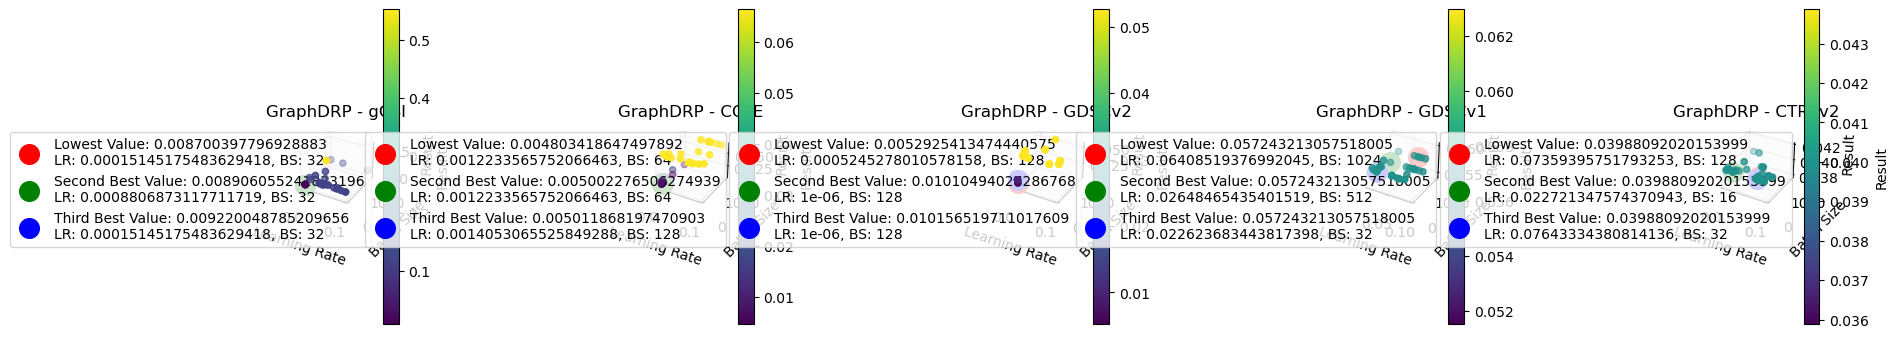

In [58]:

base_dir = "."
models = ["GraphDRP"]
# studies = ["gCSI", "GDSCv1", "CCLE", "GDSCv2"] gdscv1, CTRP not available! aug 6th 2024
studies = ["gCSI", "CCLE", "GDSCv2", "GDSCv1", "CTRPv2"]

size = "medium"

fig = plt.figure(figsize=(18, 12))
extra_min = 2

for i, model in enumerate(models):
    for j, study in enumerate(studies):
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size)
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        
        # Find the indices of the best, second best, and third best results
        sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
        min_index = sorted_indices[0]        
        min_result = results[min_index]
        min_lr = learning_rates[min_index]
        min_bs = batch_sizes[min_index]

        # Initialize second and third best indices to the first index
        second_best_index = min_index
        third_best_index = min_index

        # Find the second and third best distinct results
        for idx in sorted_indices[1:]:
            if results[idx] != min_result:
                second_best_index = idx
                break

        for idx in sorted_indices[1:]:
            if results[idx] != min_result and results[idx] != results[second_best_index]:
                third_best_index = idx
                break

        # If all results are the same, ensure we pick some other values
        if second_best_index == min_index:
            second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
        if third_best_index == min_index:
            third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

        second_best_result = results[second_best_index]
        second_best_lr = learning_rates[second_best_index]
        second_best_bs = batch_sizes[second_best_index]

        third_best_result = results[third_best_index]
        third_best_lr = learning_rates[third_best_index]
        third_best_bs = batch_sizes[third_best_index]

        
        ax = fig.add_subplot(len(models), len(studies), i * len(studies) + j + 1, projection='3d')
        scatter = ax.scatter(learning_rates, batch_sizes, results, c=results, cmap='viridis')
        ax.scatter(min_lr, min_bs, min_result, color='r', s=200, label=f'Lowest Value: {min_result} \nLR: {min_lr}, BS: {min_bs}')
        ax.scatter(second_best_lr, second_best_bs, second_best_result, color='g', s=200, label=f'Second Best Value: {second_best_result}\nLR: {second_best_lr}, BS: {second_best_bs}')
        ax.scatter(third_best_lr, third_best_bs, third_best_result, color='b', s=200, label=f'Third Best Value: {third_best_result}\nLR: {third_best_lr}, BS: {third_best_bs}')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_zlabel('Result')
        ax.set_title(f'{model} - {study}')
        ax.legend()
        fig.colorbar(scatter, ax=ax, label='Result')

plt.tight_layout()
plt.show()


# From the large and medium runs we can see that Hyperparameters are indeed different for different datasets, but, both medium and large runs almost give the same minimum optimal result and learning rate and batch size combination 
model, val_loss, learning_rate, batch_size
See below:


--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
--- Processing model: GraphDRP, study: CCLE ---
{'best': ['./GraphDRP/CCLE/MEDIUM/best-1.json'], 'log': ['./GraphDRP/CCLE/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/CCLE/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/CCLE/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/CCLE/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/CCLE/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/CCLE/MEDIUM/hpo.csv']}
--- Processing model: GraphDRP, study: GDSCv2 ---
{'best': ['./GraphDRP/GDSCv2/MEDIUM/best-14.json'], 'log': ['./GraphDRP/GDSCv2/MEDIUM/deap-14.log'], 'fitnesses': ['./

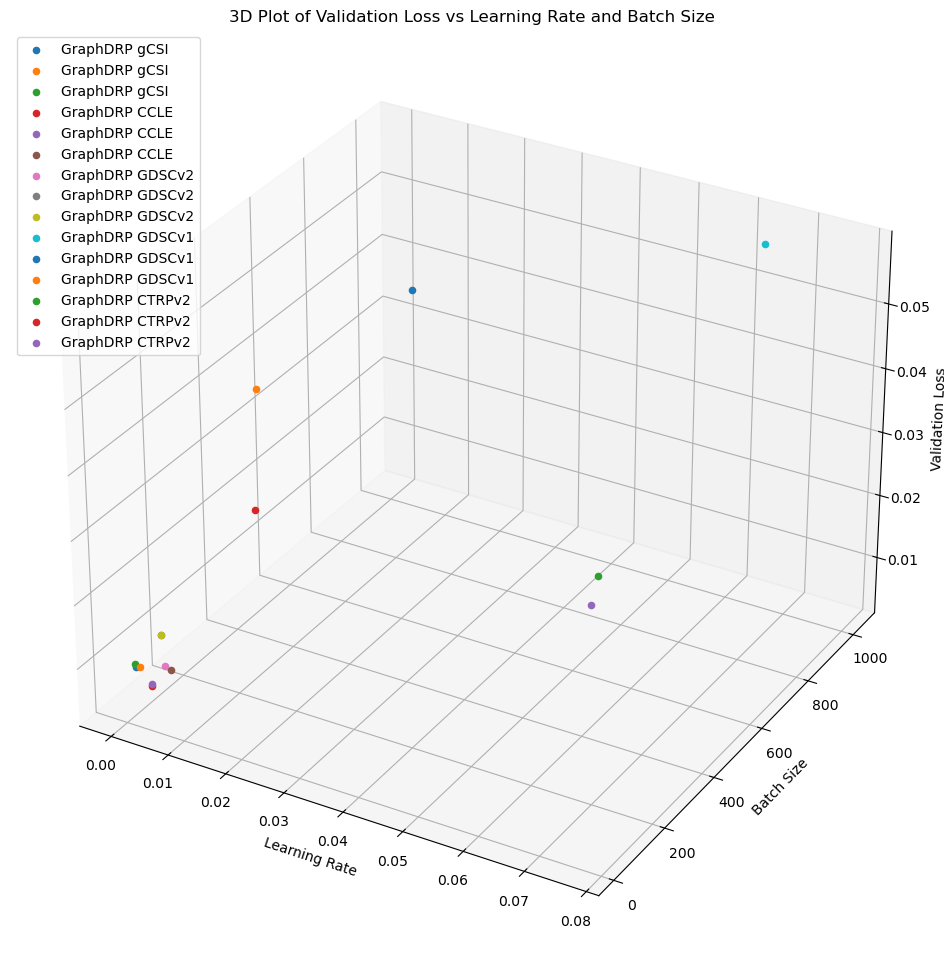

In [59]:
base_dir = "."
models = ["GraphDRP"]
studies = ["gCSI", "CCLE", "GDSCv2", "GDSCv1", "CTRPv2"]

size = "medium"

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=['model', 'study', 'val_loss', 'learning_rate', 'batch_size'])

for model in models:
    for study in studies:
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size)
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        
        # Find the indices of the best, second best, and third best results
        sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
        min_index = sorted_indices[0]        
        min_result = results[min_index]
        min_lr = learning_rates[min_index]
        min_bs = batch_sizes[min_index]

        # Initialize second and third best indices to the first index
        second_best_index = min_index
        third_best_index = min_index

        # Find the second and third best distinct results
        for idx in sorted_indices[1:]:
            if results[idx] != min_result:
                second_best_index = idx
                break

        for idx in sorted_indices[1:]:
            if results[idx] != min_result and results[idx] != results[second_best_index]:
                third_best_index = idx
                break

        # If all results are the same, ensure we pick some other values
        if second_best_index == min_index:
            second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
        if third_best_index == min_index:
            third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

        second_best_result = results[second_best_index]
        second_best_lr = learning_rates[second_best_index]
        second_best_bs = batch_sizes[second_best_index]

        third_best_result = results[third_best_index]
        third_best_lr = learning_rates[third_best_index]
        third_best_bs = batch_sizes[third_best_index]

        # Append the best, second best, and third best results to the DataFrame
        new_rows = pd.DataFrame([
            {'model': model, 'study': study, 'val_loss': min_result, 'learning_rate': min_lr, 'batch_size': min_bs},
            {'model': model, 'study': study, 'val_loss': second_best_result, 'learning_rate': second_best_lr, 'batch_size': second_best_bs},
            {'model': model, 'study': study, 'val_loss': third_best_result, 'learning_rate': third_best_lr, 'batch_size': third_best_bs}
        ])
        results_df = pd.concat([results_df, new_rows], ignore_index=True)

# Print the results DataFrame
print(results_df)

# Plotting the 3D plot for all models
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot each point
for i, row in results_df.iterrows():
    ax.scatter(row['learning_rate'], row['batch_size'], row['val_loss'], label=f"{row['model']} {row['study']}")

# Set labels
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Batch Size')
ax.set_zlabel('Validation Loss')
ax.set_title('3D Plot of Validation Loss vs Learning Rate and Batch Size')

plt.legend()
plt.show()

# IGDT


--- Processing model: IGTD, study: gCSI ---
{'best': ['./IGTD/gCSI/MEDIUM/best-8.json'], 'log': ['./IGTD/gCSI/MEDIUM/deap-8.log'], 'fitnesses': ['./IGTD/gCSI/MEDIUM/fitnesses-8.txt'], 'fitness': ['./IGTD/gCSI/MEDIUM/fitness-8.txt'], 'hyperparams': ['./IGTD/gCSI/MEDIUM/hyperparams.IGTD.gCSI.medium.json'], 'cfg': [], 'hpo': ['./IGTD/gCSI/MEDIUM/hpo.csv']}
--- Processing model: IGTD, study: CCLE ---
{'best': ['./IGTD/CCLE/MEDIUM/best-8.json'], 'log': ['./IGTD/CCLE/MEDIUM/deap-8.log'], 'fitnesses': ['./IGTD/CCLE/MEDIUM/fitnesses-8.txt'], 'fitness': ['./IGTD/CCLE/MEDIUM/fitness-8.txt'], 'hyperparams': ['./IGTD/CCLE/MEDIUM/hyperparams.IGTD.CCLE.medium.json'], 'cfg': [], 'hpo': ['./IGTD/CCLE/MEDIUM/hpo.csv']}
--- Processing model: IGTD, study: GDSCv2 ---
{'best': ['./IGTD/GDSCv2/MEDIUM/best-8.json'], 'log': ['./IGTD/GDSCv2/MEDIUM/deap-8.log'], 'fitnesses': ['./IGTD/GDSCv2/MEDIUM/fitnesses-8.txt'], 'fitness': ['./IGTD/GDSCv2/MEDIUM/fitness-8.txt'], 'hyperparams': ['./IGTD/GDSCv2/MEDIUM/hyperpa

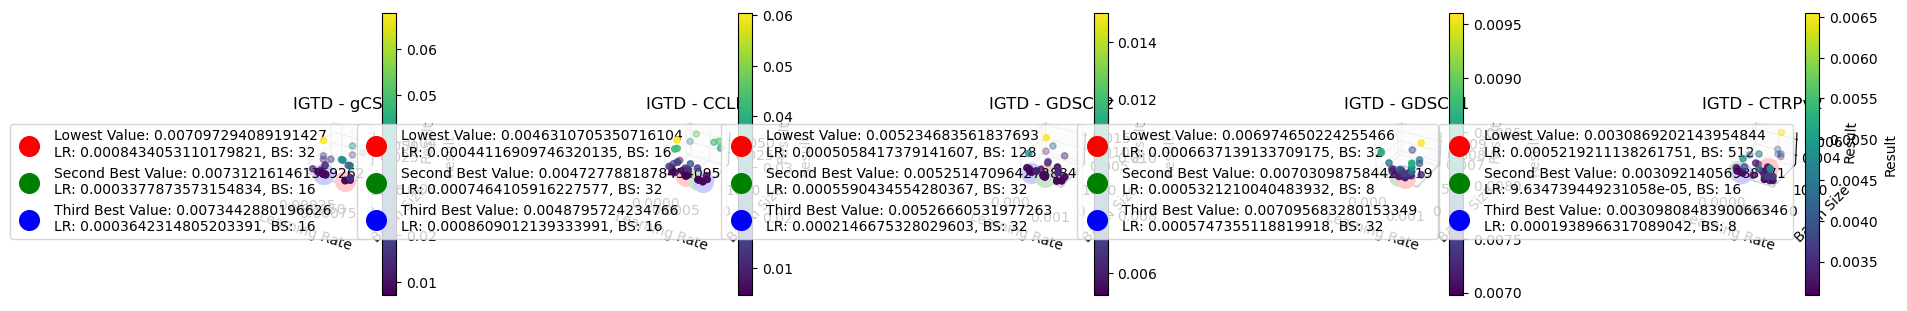

In [60]:

base_dir = "."
models = ["IGTD"]
# studies = ["gCSI", "GDSCv1", "CCLE", "GDSCv2"] gdscv1, CTRP not available! aug 6th 2024
studies = ["gCSI", "CCLE", "GDSCv2", "GDSCv1", "CTRPv2"]

size = "medium"

fig = plt.figure(figsize=(18, 12))
extra_min = 2

for i, model in enumerate(models):
    for j, study in enumerate(studies):
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size)
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        
        # Find the indices of the best, second best, and third best results
        sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
        min_index = sorted_indices[0]        
        min_result = results[min_index]
        min_lr = learning_rates[min_index]
        min_bs = batch_sizes[min_index]

        # Initialize second and third best indices to the first index
        second_best_index = min_index
        third_best_index = min_index

        # Find the second and third best distinct results
        for idx in sorted_indices[1:]:
            if results[idx] != min_result:
                second_best_index = idx
                break

        for idx in sorted_indices[1:]:
            if results[idx] != min_result and results[idx] != results[second_best_index]:
                third_best_index = idx
                break

        # If all results are the same, ensure we pick some other values
        if second_best_index == min_index:
            second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
        if third_best_index == min_index:
            third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

        second_best_result = results[second_best_index]
        second_best_lr = learning_rates[second_best_index]
        second_best_bs = batch_sizes[second_best_index]

        third_best_result = results[third_best_index]
        third_best_lr = learning_rates[third_best_index]
        third_best_bs = batch_sizes[third_best_index]

        
        ax = fig.add_subplot(len(models), len(studies), i * len(studies) + j + 1, projection='3d')
        scatter = ax.scatter(learning_rates, batch_sizes, results, c=results, cmap='viridis')
        ax.scatter(min_lr, min_bs, min_result, color='r', s=200, label=f'Lowest Value: {min_result} \nLR: {min_lr}, BS: {min_bs}')
        ax.scatter(second_best_lr, second_best_bs, second_best_result, color='g', s=200, label=f'Second Best Value: {second_best_result}\nLR: {second_best_lr}, BS: {second_best_bs}')
        ax.scatter(third_best_lr, third_best_bs, third_best_result, color='b', s=200, label=f'Third Best Value: {third_best_result}\nLR: {third_best_lr}, BS: {third_best_bs}')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_zlabel('Result')
        ax.set_title(f'{model} - {study}')
        ax.legend()
        fig.colorbar(scatter, ax=ax, label='Result')

plt.tight_layout()
plt.show()


# IGTD large

--- Processing model: IGTD, study: gCSI ---
{'best': ['./IGTD/gCSI/LARGE/best-8.json'], 'log': ['./IGTD/gCSI/LARGE/deap-8.log'], 'fitnesses': ['./IGTD/gCSI/LARGE/fitnesses-8.txt'], 'fitness': ['./IGTD/gCSI/LARGE/fitness-8.txt'], 'hyperparams': ['./IGTD/gCSI/LARGE/hyperparams.IGTD.gCSI.large.json'], 'cfg': [], 'hpo': ['./IGTD/gCSI/LARGE/hpo.csv']}
--- Processing model: IGTD, study: CCLE ---
{'best': ['./IGTD/CCLE/LARGE/best-8.json'], 'log': ['./IGTD/CCLE/LARGE/deap-8.log'], 'fitnesses': ['./IGTD/CCLE/LARGE/fitnesses-8.txt'], 'fitness': ['./IGTD/CCLE/LARGE/fitness-8.txt'], 'hyperparams': ['./IGTD/CCLE/LARGE/hyperparams.IGTD.CCLE.large.json'], 'cfg': [], 'hpo': ['./IGTD/CCLE/LARGE/hpo.csv']}
--- Processing model: IGTD, study: GDSCv2 ---
{'best': ['./IGTD/GDSCv2/LARGE/best-8.json'], 'log': ['./IGTD/GDSCv2/LARGE/deap-8.log'], 'fitnesses': ['./IGTD/GDSCv2/LARGE/fitnesses-8.txt'], 'fitness': ['./IGTD/GDSCv2/LARGE/fitness-8.txt'], 'hyperparams': ['./IGTD/GDSCv2/LARGE/hyperparams.IGTD.GDSCv2.la

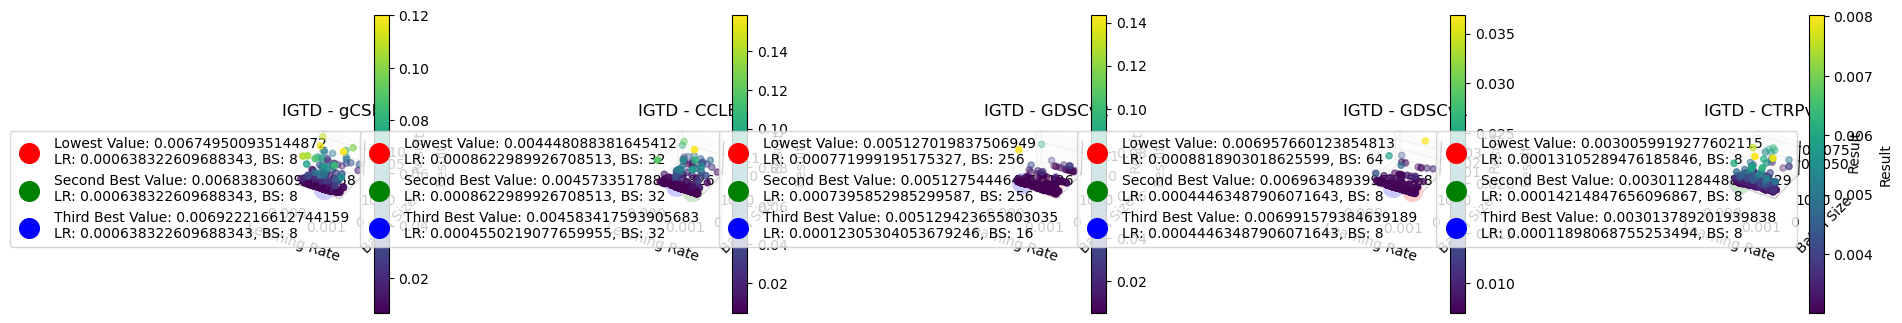

In [61]:

base_dir = "."
models = ["IGTD"]
# studies = ["gCSI", "GDSCv1", "CCLE", "GDSCv2"] gdscv1, CTRP not available! aug 6th 2024
studies = ["gCSI", "CCLE", "GDSCv2", "GDSCv1", "CTRPv2"]

size = "large"

fig = plt.figure(figsize=(18, 12))
extra_min = 2

for i, model in enumerate(models):
    for j, study in enumerate(studies):
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size)
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        
        # Find the indices of the best, second best, and third best results
        sorted_indices = sorted(range(len(results)), key=lambda k: results[k])
        min_index = sorted_indices[0]        
        min_result = results[min_index]
        min_lr = learning_rates[min_index]
        min_bs = batch_sizes[min_index]

        # Initialize second and third best indices to the first index
        second_best_index = min_index
        third_best_index = min_index

        # Find the second and third best distinct results
        for idx in sorted_indices[1:]:
            if results[idx] != min_result:
                second_best_index = idx
                break

        for idx in sorted_indices[1:]:
            if results[idx] != min_result and results[idx] != results[second_best_index]:
                third_best_index = idx
                break

        # If all results are the same, ensure we pick some other values
        if second_best_index == min_index:
            second_best_index = sorted_indices[1] if len(sorted_indices) > 1 else min_index
        if third_best_index == min_index:
            third_best_index = sorted_indices[2] if len(sorted_indices) > 2 else (sorted_indices[1] if len(sorted_indices) > 1 else min_index)

        second_best_result = results[second_best_index]
        second_best_lr = learning_rates[second_best_index]
        second_best_bs = batch_sizes[second_best_index]

        third_best_result = results[third_best_index]
        third_best_lr = learning_rates[third_best_index]
        third_best_bs = batch_sizes[third_best_index]

        
        ax = fig.add_subplot(len(models), len(studies), i * len(studies) + j + 1, projection='3d')
        scatter = ax.scatter(learning_rates, batch_sizes, results, c=results, cmap='viridis')
        ax.scatter(min_lr, min_bs, min_result, color='r', s=200, label=f'Lowest Value: {min_result} \nLR: {min_lr}, BS: {min_bs}')
        ax.scatter(second_best_lr, second_best_bs, second_best_result, color='g', s=200, label=f'Second Best Value: {second_best_result}\nLR: {second_best_lr}, BS: {second_best_bs}')
        ax.scatter(third_best_lr, third_best_bs, third_best_result, color='b', s=200, label=f'Third Best Value: {third_best_result}\nLR: {third_best_lr}, BS: {third_best_bs}')
        
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Batch Size')
        ax.set_zlabel('Result')
        ax.set_title(f'{model} - {study}')
        ax.legend()
        fig.colorbar(scatter, ax=ax, label='Result')

plt.tight_layout()
plt.show()


In [65]:
models = ["GraphDRP", "IGTD", "Paccmann_MCA", "PathDSP", "HiDRA", "LGBM"]
studies = ["gCSI", "CCLE"]
size = "medium"

# Plot learning rate and batch size variations for all models and datasets individually

--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
--- Processing model: GraphDRP, study: CCLE ---
{'best': ['./GraphDRP/CCLE/MEDIUM/best-1.json'], 'log': ['./GraphDRP/CCLE/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/CCLE/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/CCLE/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/CCLE/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/CCLE/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/CCLE/MEDIUM/hpo.csv']}
--- Processing model: IGTD, study: gCSI ---
{'best': ['./IGTD/gCSI/MEDIUM/best-8.json'], 'log': ['./IGTD/gCSI/MEDIUM/deap-8.log'], 'fitnesses': ['./IGTD/gCSI/MEDIUM/fit

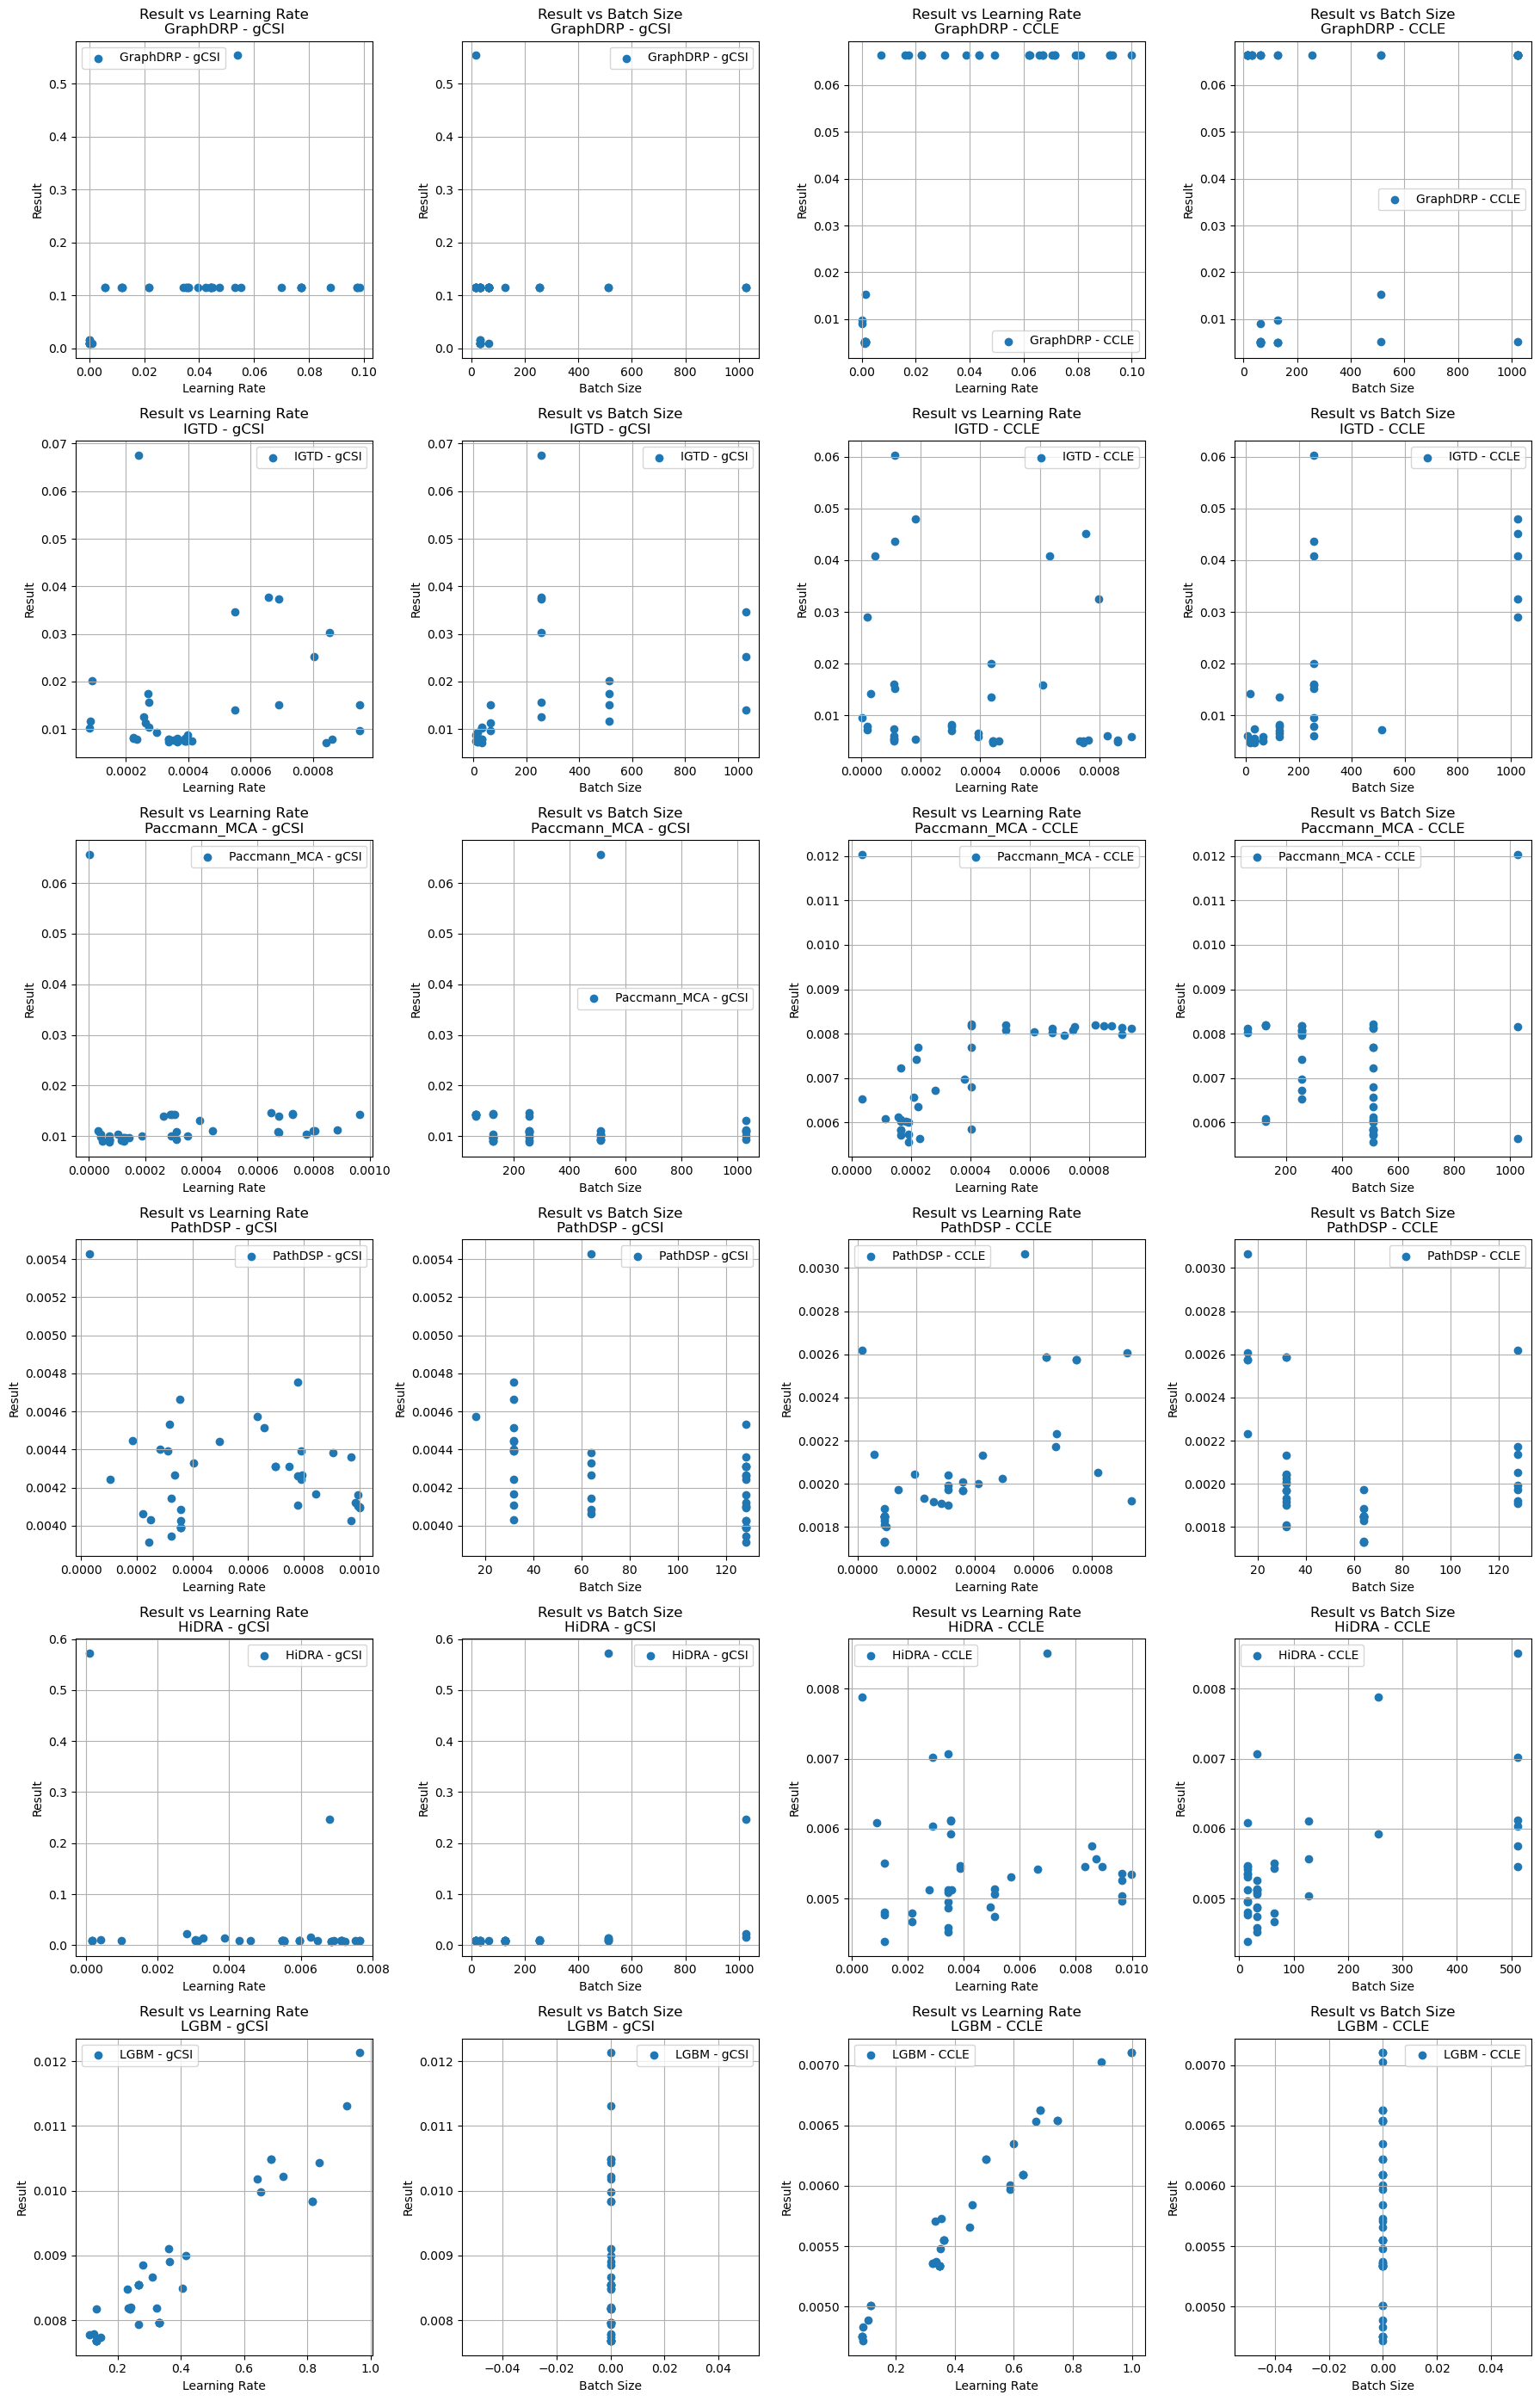

In [70]:
fig, axes = plt.subplots(len(models), len(studies) * 2, figsize=(18, 28))

for i, model in enumerate(models):
    for j, study in enumerate(studies):
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size)
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        
        label = f"{model} - {study}"
        
        # Plot Result vs Learning Rate
        ax = axes[i, j*2]
        ax.scatter(learning_rates, results, label=label)
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Result')
        ax.set_title(f'Result vs Learning Rate\n{label}')
        ax.legend()
        ax.grid(True)
        
        # Plot Result vs Batch Size
        ax = axes[i, j*2+1]
        ax.scatter(batch_sizes, results, label=label)
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Result')
        ax.set_title(f'Result vs Batch Size\n{label}')
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()

--- Processing model: GraphDRP, study: gCSI ---
{'best': ['./GraphDRP/gCSI/MEDIUM/best-1.json'], 'log': ['./GraphDRP/gCSI/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/gCSI/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/gCSI/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/gCSI/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/gCSI/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/gCSI/MEDIUM/hpo.csv']}
--- Processing model: GraphDRP, study: CCLE ---
{'best': ['./GraphDRP/CCLE/MEDIUM/best-1.json'], 'log': ['./GraphDRP/CCLE/MEDIUM/deap-1.log'], 'fitnesses': ['./GraphDRP/CCLE/MEDIUM/fitnesses-1.txt'], 'fitness': ['./GraphDRP/CCLE/MEDIUM/fitness-1.txt'], 'hyperparams': ['./GraphDRP/CCLE/MEDIUM/graphdrp_param_space-3.json'], 'cfg': ['./GraphDRP/CCLE/MEDIUM/cfg-gdrp-1.sh'], 'hpo': ['./GraphDRP/CCLE/MEDIUM/hpo.csv']}
--- Processing model: IGTD, study: gCSI ---
{'best': ['./IGTD/gCSI/MEDIUM/best-8.json'], 'log': ['./IGTD/gCSI/MEDIUM/deap-8.log'], 'fitnesses': ['./IGTD/gCSI/MEDIUM/fit

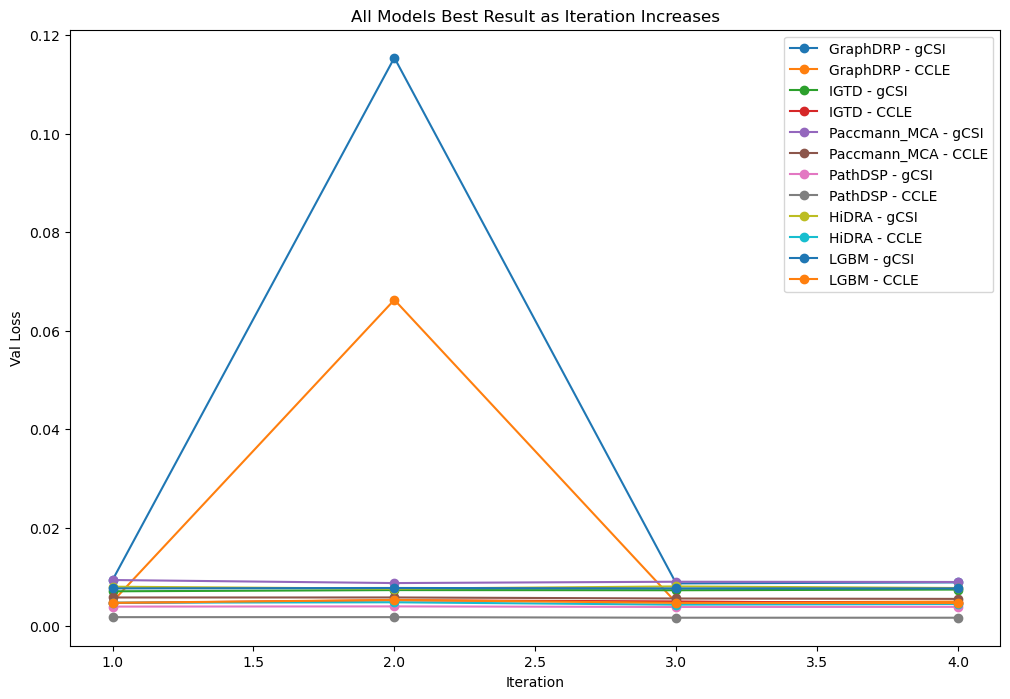

In [64]:
import matplotlib.pyplot as plt

def get_smallest_values(results, iterations):
    """Calculate the smallest values for each iteration."""
    min_results = {}
    for iteration, result in zip(iterations, results):
        if iteration not in min_results:
            min_results[iteration] = result
        else:
            if result < min_results[iteration]:
                min_results[iteration] = result
    # Sort by iteration and extract values
    sorted_iterations = sorted(min_results.keys())
    sorted_values = [min_results[it] for it in sorted_iterations]
    return sorted_iterations, sorted_values

plt.figure(figsize=(12, 8))
all_data = []
models = ["GraphDRP", "IGTD", "Paccmann_MCA", "PathDSP", "HiDRA", "LGBM"]
studies = ["gCSI", "CCLE"]
size = "medium"

for model in models:
    for study in studies:
        print(f"--- Processing model: {model}, study: {study} ---")
        data = parse_files(base_dir, model, study, size)
        all_data.append(data)
        
        hpo_data = data['hpo'][0]
        iterations, results, learning_rates, batch_sizes = extract_values(hpo_data)
        
        # Get the smallest values for each iteration
        sorted_iterations, smallest_values = get_smallest_values(results, iterations)
        
        label = f"{model} - {study}"
        plt.plot(sorted_iterations, smallest_values, marker='o', label=label)

plt.xlabel('Iteration')
plt.ylabel('Val Loss')
plt.title('All Models Best Result as Iteration Increases')
plt.legend()
plt.show()


In [ ]:
# starts with default parameters - 
# start with random for one to see the trend
